# Hoh River Sub-Daily Streamflow Prediction with Deep Learning

Training automatic feature learning models on **15-minute USGS data** from Hoh River, Olympic National Park, Washington.

## Data Source:
- **Location**: Hoh River at US Highway 101 near Forks, WA
- **USGS Site**: 12041200  
- **Period**: **2015-2025 (Last 10 years)** - filtered for faster training
- **Records**: ~380,000 instantaneous values at 15-minute intervals → aggregated to hourly
- **Drainage Area**: 253 square miles
- **Climate**: Temperate rainforest (rain-dominated)

## Why Sub-Daily Data?
Rain-dominated systems like the Hoh River experience **rapid flow changes** from storm events (Noah Effect). Daily data averages smooth out these peaks. Sub-daily data captures:
- Storm hydrograph shape (rapid rise and gradual recession)
- Intra-day variability from atmospheric river events
- Diurnal patterns (if present)

## Hypothesis:
**Daily data R² ≈ 0.66** → Can sub-daily resolution improve predictions by capturing storm dynamics?

## Approach:
- Filter to last 10 years (2015-2025) for manageable training time
- Aggregate 15-min data to **hourly** (compromise between resolution and sequence length)
- Use 7 days of hourly history (168 timesteps)
- Compare to daily model performance

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

Using device: cuda
GPU: NVIDIA GeForce GTX 1070


## Load and Aggregate Sub-Daily Data

15-minute data loaded: 895,986 records
Full date range: 1990-01-01 08:00:00+00:00 to 2025-11-22 18:15:00+00:00

Filtered to last 10 years: 380,558 records
Date range: 2015-01-01 00:00:00+00:00 to 2025-11-22 18:15:00+00:00
Duration: 10.9 years

Aggregated to hourly: 95,233 records
Records per day: 23.9

Streamflow statistics (m³/s):
count    95233.000000
mean        69.865745
std         78.142149
min          5.012074
25%         30.652936
50%         47.289056
75%         78.295952
max       1374.780640
Name: streamflow, dtype: float64


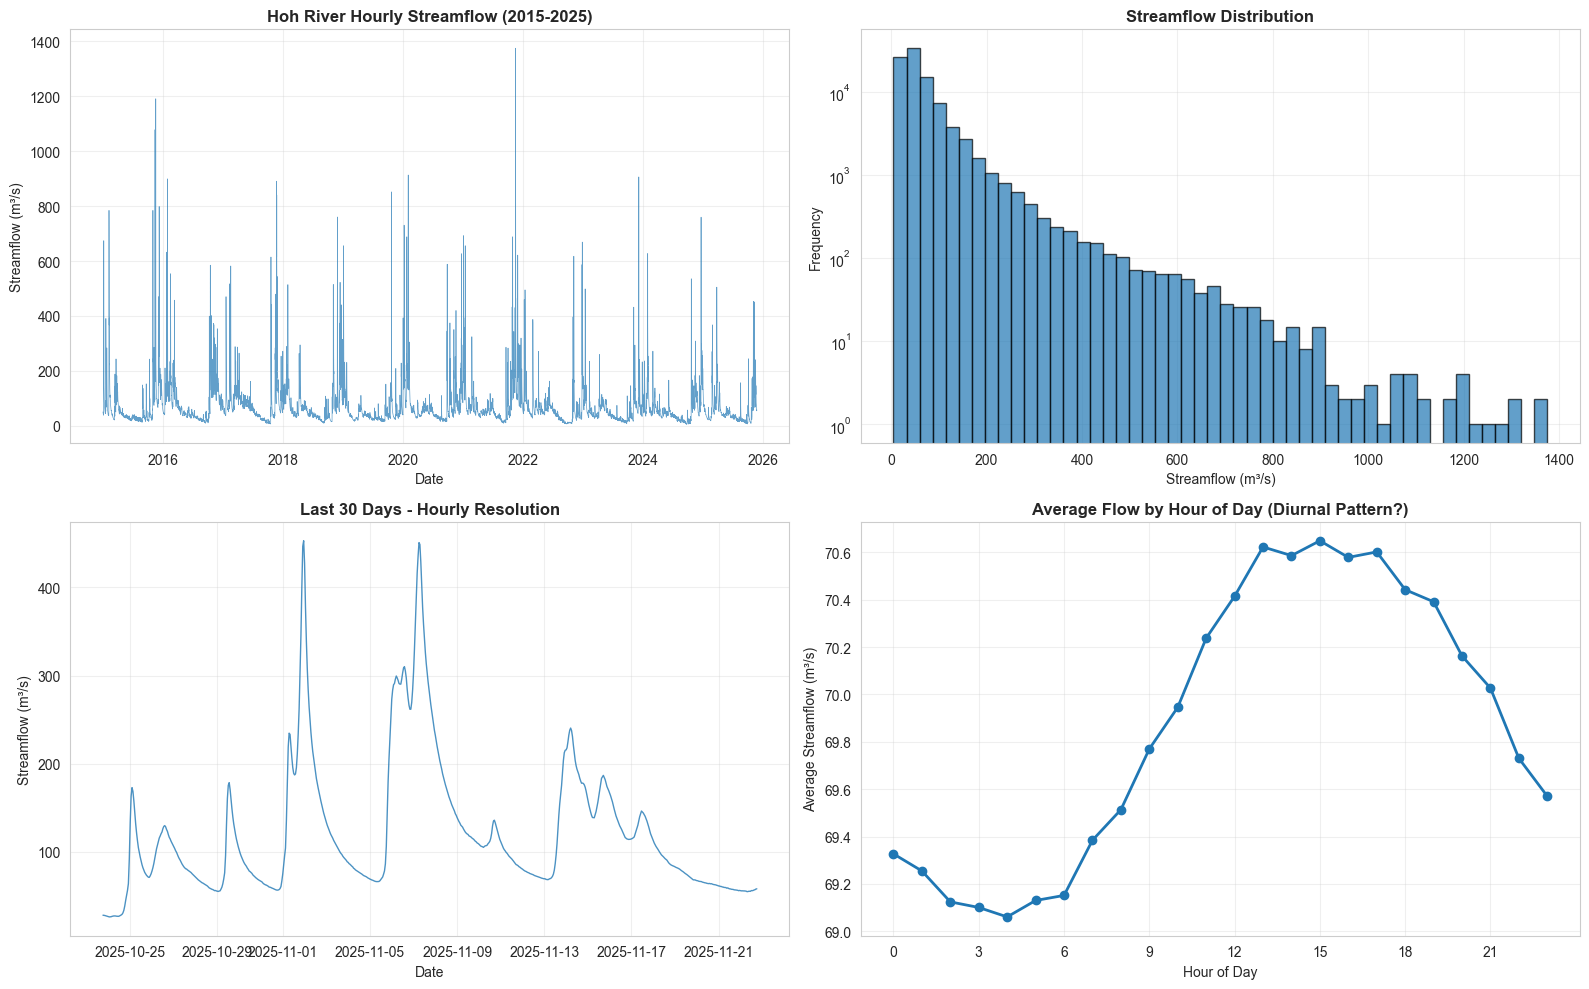

In [11]:
# Load 15-minute data
df_15min = pd.read_csv('../data/hoh_river_subdaily_full.csv')
df_15min['datetime'] = pd.to_datetime(df_15min['datetime'])

print(f"15-minute data loaded: {len(df_15min):,} records")
print(f"Full date range: {df_15min['datetime'].min()} to {df_15min['datetime'].max()}")

# Filter to last 10 years only (2015-2025)
# Use timezone-aware timestamp to match the data
cutoff_date = pd.Timestamp('2015-01-01', tz='UTC')
df_15min = df_15min[df_15min['datetime'] >= cutoff_date]

print(f"\nFiltered to last 10 years: {len(df_15min):,} records")
print(f"Date range: {df_15min['datetime'].min()} to {df_15min['datetime'].max()}")
print(f"Duration: {(df_15min['datetime'].max() - df_15min['datetime'].min()).days / 365.25:.1f} years")

# Aggregate to hourly (take mean of 4x 15-minute values)
df_15min.set_index('datetime', inplace=True)
df_hourly = df_15min.resample('1H').agg({
    'streamflow': 'mean',
    'streamflow_cfs': 'mean'
}).dropna().reset_index()

print(f"\nAggregated to hourly: {len(df_hourly):,} records")
print(f"Records per day: {len(df_hourly) / ((df_hourly['datetime'].max() - df_hourly['datetime'].min()).days):.1f}")

print(f"\nStreamflow statistics (m³/s):")
print(df_hourly['streamflow'].describe())

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Full time series (last 10 years)
axes[0, 0].plot(df_hourly['datetime'], df_hourly['streamflow'], linewidth=0.5, alpha=0.7)
axes[0, 0].set_title('Hoh River Hourly Streamflow (2015-2025)', fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Streamflow (m³/s)')
axes[0, 0].grid(True, alpha=0.3)

# Distribution
axes[0, 1].hist(df_hourly['streamflow'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Streamflow Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Streamflow (m³/s)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3)

# Recent 30 days to show hourly detail
recent_30d = df_hourly[df_hourly['datetime'] >= df_hourly['datetime'].max() - pd.Timedelta(days=30)]
axes[1, 0].plot(recent_30d['datetime'], recent_30d['streamflow'], linewidth=1, alpha=0.8)
axes[1, 0].set_title('Last 30 Days - Hourly Resolution', fontweight='bold')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Streamflow (m³/s)')
axes[1, 0].grid(True, alpha=0.3)

# Diurnal pattern check (average by hour of day)
df_hourly['hour'] = df_hourly['datetime'].dt.hour
hourly_avg = df_hourly.groupby('hour')['streamflow'].mean()
axes[1, 1].plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2)
axes[1, 1].set_title('Average Flow by Hour of Day (Diurnal Pattern?)', fontweight='bold')
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Average Streamflow (m³/s)')
axes[1, 1].set_xticks(range(0, 24, 3))
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Prepare Data for Deep Learning

In [12]:
def create_sequences_raw(data, seq_length=168, forecast_horizon=1):
    """Create sequences from raw time series data."""
    X, y = [], []
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    X = np.array(X).reshape(-1, seq_length, 1)
    return X, np.array(y)

# Use only streamflow values (automatic feature learning!)
streamflow_values = df_hourly['streamflow'].values

# Split: 70% train, 15% val, 15% test
train_size = int(0.70 * len(streamflow_values))
val_size = int(0.15 * len(streamflow_values))

train_data = streamflow_values[:train_size]
val_data = streamflow_values[train_size:train_size + val_size]
test_data = streamflow_values[train_size + val_size:]

print(f"Training period: {df_hourly['datetime'].iloc[0]} to {df_hourly['datetime'].iloc[train_size-1]}")
print(f"Validation period: {df_hourly['datetime'].iloc[train_size]} to {df_hourly['datetime'].iloc[train_size+val_size-1]}")
print(f"Test period: {df_hourly['datetime'].iloc[train_size+val_size]} to {df_hourly['datetime'].iloc[-1]}")

# Scale data
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data.reshape(-1, 1)).flatten()
val_data_scaled = scaler.transform(val_data.reshape(-1, 1)).flatten()
test_data_scaled = scaler.transform(test_data.reshape(-1, 1)).flatten()

# Create sequences
# 7 days * 24 hours = 168 timesteps (equivalent to 7 days of hourly history)
# vs daily model's 60 days
SEQ_LENGTH = 168
X_train, y_train = create_sequences_raw(train_data_scaled, SEQ_LENGTH)
X_val, y_val = create_sequences_raw(val_data_scaled, SEQ_LENGTH)
X_test, y_test = create_sequences_raw(test_data_scaled, SEQ_LENGTH)

print(f"\nSequence shapes:")
print(f"  Train: {X_train.shape} -> {y_train.shape}")
print(f"  Val:   {X_val.shape} -> {y_val.shape}")
print(f"  Test:  {X_test.shape} -> {y_test.shape}")

print(f"\nSequence configuration:")
print(f"  Lookback: {SEQ_LENGTH} hours ({SEQ_LENGTH/24:.1f} days)")
print(f"  Forecast: 1 hour ahead")

# Convert to PyTorch
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.FloatTensor(y_val).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

# DataLoaders
BATCH_SIZE = 64
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=BATCH_SIZE, shuffle=False)

print(f"\n✓ Data ready for training!")
print(f"✓ Using raw hourly streamflow only - model will learn features automatically")
print(f"✓ {len(X_train):,} training sequences at {SEQ_LENGTH}-hour lookback")

Training period: 2015-01-01 00:00:00+00:00 to 2022-08-17 22:00:00+00:00
Validation period: 2022-08-17 23:00:00+00:00 to 2024-04-04 02:00:00+00:00
Test period: 2024-04-04 03:00:00+00:00 to 2025-11-22 18:00:00+00:00

Sequence shapes:
  Train: (66495, 168, 1) -> (66495,)
  Val:   (14116, 168, 1) -> (14116,)
  Test:  (14118, 168, 1) -> (14118,)

Sequence configuration:
  Lookback: 168 hours (7.0 days)
  Forecast: 1 hour ahead

✓ Data ready for training!
✓ Using raw hourly streamflow only - model will learn features automatically
✓ 66,495 training sequences at 168-hour lookback


## Model Architectures

Same architectures as daily model, adapted for longer sequences (168 vs 60 timesteps)

In [13]:
class DeepLSTM(nn.Module):
    """Deep LSTM with multiple layers for hierarchical feature learning"""
    def __init__(self, input_size=1, hidden_sizes=[128, 64, 32], dropout=0.3):
        super(DeepLSTM, self).__init__()
        
        # Stack multiple LSTM layers
        self.lstm_layers = nn.ModuleList()
        
        # First layer
        self.lstm_layers.append(
            nn.LSTM(input_size, hidden_sizes[0], batch_first=True)
        )
        
        # Middle layers
        for i in range(len(hidden_sizes) - 1):
            self.lstm_layers.append(
                nn.LSTM(hidden_sizes[i], hidden_sizes[i+1], batch_first=True)
            )
        
        self.dropout = nn.Dropout(dropout)
        
        # Output layer
        self.fc = nn.Linear(hidden_sizes[-1], 1)
    
    def forward(self, x):
        # Pass through each LSTM layer
        for lstm in self.lstm_layers:
            x, _ = lstm(x)
            x = self.dropout(x)
        
        # Take last time step
        x = x[:, -1, :]
        out = self.fc(x)
        return out.squeeze()


class AttentionLSTM(nn.Module):
    """LSTM with attention mechanism to learn important time steps"""
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, dropout=0.2):
        super(AttentionLSTM, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1)
        )
    
    def forward(self, x):
        # Get LSTM outputs for all time steps
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, hidden_size)
        
        # Calculate attention weights
        attention_weights = self.attention(lstm_out)  # (batch, seq_len, 1)
        attention_weights = torch.softmax(attention_weights, dim=1)
        
        # Apply attention weights
        context = torch.sum(attention_weights * lstm_out, dim=1)  # (batch, hidden_size)
        
        out = self.fc(context)
        return out.squeeze()


class TemporalConvNet(nn.Module):
    """Temporal Convolutional Network for efficient local pattern learning"""
    def __init__(self, input_size=1, num_channels=[64, 128, 64], kernel_size=3, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        
        layers = []
        num_levels = len(num_channels)
        
        for i in range(num_levels):
            in_channels = input_size if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            
            # Dilated causal convolution
            dilation = 2 ** i
            padding = (kernel_size - 1) * dilation
            
            layers.extend([
                nn.Conv1d(in_channels, out_channels, kernel_size, 
                         padding=padding, dilation=dilation),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Conv1d(out_channels, out_channels, kernel_size,
                         padding=padding, dilation=dilation),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
        
        self.network = nn.Sequential(*layers)
        self.fc = nn.Linear(num_channels[-1], 1)
    
    def forward(self, x):
        # x shape: (batch, seq_len, features)
        # Conv1d expects: (batch, features, seq_len)
        x = x.transpose(1, 2)
        
        x = self.network(x)
        
        # Global average pooling
        x = torch.mean(x, dim=2)
        
        out = self.fc(x)
        return out.squeeze()


class TransformerModel(nn.Module):
    """Transformer with self-attention for long-range dependencies"""
    def __init__(self, input_size=1, d_model=128, nhead=8, num_layers=3, dropout=0.2):
        super(TransformerModel, self).__init__()
        
        # Input projection
        self.input_proj = nn.Linear(input_size, d_model)
        
        # Learnable positional encoding (increased for longer sequences)
        self.pos_encoder = nn.Parameter(torch.randn(1, 500, d_model))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output layers
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1)
        )
    
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        
        # Project and add positional encoding
        x = self.input_proj(x)
        x = x + self.pos_encoder[:, :seq_len, :]
        
        # Transformer encoding
        x = self.transformer(x)
        
        # Use last time step
        x = x[:, -1, :]
        out = self.fc(x)
        return out.squeeze()


print("✅ Model architectures defined")
print("\nAvailable models:")
print("  1. DeepLSTM - Multiple LSTM layers for hierarchical learning")
print("  2. AttentionLSTM - LSTM with attention to identify important time steps")
print("  3. TemporalConvNet (TCN) - Efficient convolutional approach")
print("  4. TransformerModel - Self-attention for long-range dependencies")
print("\nNote: All adapted for longer sequences (168 hours vs 60 days)")

✅ Model architectures defined

Available models:
  1. DeepLSTM - Multiple LSTM layers for hierarchical learning
  2. AttentionLSTM - LSTM with attention to identify important time steps
  3. TemporalConvNet (TCN) - Efficient convolutional approach
  4. TransformerModel - Self-attention for long-range dependencies

Note: All adapted for longer sequences (168 hours vs 60 days)


## Training Functions

In [14]:
def train_model(model, train_loader, val_loader, epochs=50, lr=0.001, patience=15):
    """Train a model and return history"""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_losses.append(loss.item())
        
        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_losses.append(loss.item())
        
        avg_train_loss = np.mean(train_losses)
        avg_val_loss = np.mean(val_losses)
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        
        scheduler.step(avg_val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save best model
            best_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Load best model
    model.load_state_dict(best_state)
    return history, best_val_loss


def evaluate_model(model, data_loader, scaler):
    """Evaluate model and return predictions and metrics"""
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            outputs = model(batch_X)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(batch_y.cpu().numpy())
    
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    # Inverse transform
    predictions_original = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    actuals_original = scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(actuals_original, predictions_original))
    mae = mean_absolute_error(actuals_original, predictions_original)
    r2 = r2_score(actuals_original, predictions_original)
    nse = 1 - (np.sum((actuals_original - predictions_original) ** 2) / 
               np.sum((actuals_original - np.mean(actuals_original)) ** 2))
    
    metrics = {'RMSE': rmse, 'MAE': mae, 'R²': r2, 'NSE': nse}
    
    return predictions_original, actuals_original, metrics

## Training and Evaluation

In [15]:
# Define all models
models = {
    'DeepLSTM': DeepLSTM(input_size=1, hidden_sizes=[128, 64, 32], dropout=0.3),
    'AttentionLSTM': AttentionLSTM(input_size=1, hidden_size=128, num_layers=2, dropout=0.2),
    'TCN': TemporalConvNet(input_size=1, num_channels=[64, 128, 64], dropout=0.2),
    'Transformer': TransformerModel(input_size=1, d_model=128, nhead=8, num_layers=3, dropout=0.2)
}

# Training configuration
EPOCHS = 50
LEARNING_RATE = 0.001

results = {}

print("Starting training for all models...\n")
print("=" * 80)

for name, model in models.items():
    print(f"\nTraining {name}...")
    print("-" * 80)
    
    model = model.to(device)
    
    # Count parameters
    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Parameters: {n_params:,}")
    
    # Train
    history, best_val_loss = train_model(model, train_loader, val_loader, 
                                          epochs=EPOCHS, lr=LEARNING_RATE)
    
    # Evaluate
    test_preds, test_actuals, test_metrics = evaluate_model(model, test_loader, scaler)
    
    results[name] = {
        'model': model,
        'history': history,
        'test_preds': test_preds,
        'test_actuals': test_actuals,
        'metrics': test_metrics,
        'n_params': n_params
    }
    
    print(f"\nTest Results:")
    print(f"  RMSE: {test_metrics['RMSE']:.3f}")
    print(f"  MAE:  {test_metrics['MAE']:.3f}")
    print(f"  R²:   {test_metrics['R²']:.4f}")
    print(f"  NSE:  {test_metrics['NSE']:.4f}")

print("\n" + "=" * 80)
print("✅ All models trained!")

Starting training for all models...


Training DeepLSTM...
--------------------------------------------------------------------------------
Parameters: 129,313
Epoch [10/50] | Train Loss: 0.020651 | Val Loss: 0.001520
Epoch [20/50] | Train Loss: 0.017880 | Val Loss: 0.000829
Epoch [30/50] | Train Loss: 0.016651 | Val Loss: 0.000767
Epoch [40/50] | Train Loss: 0.015991 | Val Loss: 0.000981
Epoch [50/50] | Train Loss: 0.015061 | Val Loss: 0.000601

Test Results:
  RMSE: 1.827
  MAE:  0.713
  R²:   0.9990
  NSE:  0.9990

Training AttentionLSTM...
--------------------------------------------------------------------------------
Parameters: 224,130
Epoch [10/50] | Train Loss: 0.016158 | Val Loss: 0.005481
Epoch [20/50] | Train Loss: 0.012665 | Val Loss: 0.001429
Epoch [30/50] | Train Loss: 0.011360 | Val Loss: 0.000720
Epoch [40/50] | Train Loss: 0.010198 | Val Loss: 0.001079
Epoch [50/50] | Train Loss: 0.010144 | Val Loss: 0.000502

Test Results:
  RMSE: 1.732
  MAE:  0.818
  R²:   0.9991
 

## Results Comparison

In [16]:
# Compare all models
print("\n" + "=" * 80)
print("MODEL COMPARISON - HOURLY SUB-DAILY DATA")
print("=" * 80)

comparison_data = []
for name, result in results.items():
    comparison_data.append({
        'Model': name,
        'Parameters': f"{result['n_params']:,}",
        'RMSE': f"{result['metrics']['RMSE']:.4f}",
        'MAE': f"{result['metrics']['MAE']:.4f}",
        'R²': f"{result['metrics']['R²']:.4f}",
        'NSE': f"{result['metrics']['NSE']:.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

# Find best model
best_model_name = min(results.items(), key=lambda x: x[1]['metrics']['RMSE'])[0]
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   RMSE: {results[best_model_name]['metrics']['RMSE']:.4f}")
print(f"   R²: {results[best_model_name]['metrics']['R²']:.4f}")

print("\n" + "=" * 80)
print("COMPARISON TO DAILY DATA MODEL")
print("=" * 80)
print("\nDaily data model (hoh_river_model.ipynb):")
print("  R² ≈ 0.66-0.67")
print("  RMSE ≈ 40 m³/s")
print("\nSub-daily (hourly) model:")
print(f"  R² = {results[best_model_name]['metrics']['R²']:.4f}")
print(f"  RMSE = {results[best_model_name]['metrics']['RMSE']:.4f} m³/s")

if results[best_model_name]['metrics']['R²'] > 0.67:
    improvement = (results[best_model_name]['metrics']['R²'] - 0.67) / 0.67 * 100
    print(f"\n✅ Hourly data IMPROVED R² by {improvement:.1f}%")
    print("   → Sub-daily resolution captures storm dynamics better!")
else:
    print(f"\n⚠️  Similar or worse performance than daily data")
    print("   → Hourly resolution may add noise without enough signal")


MODEL COMPARISON - HOURLY SUB-DAILY DATA

         Model Parameters   RMSE    MAE     R²    NSE
     DeepLSTM    129,313 1.8272 0.7126 0.9990 0.9990
AttentionLSTM    224,130 1.7319 0.8177 0.9991 0.9991
          TCN    123,649 5.3056 4.4688 0.9913 0.9913
  Transformer    667,393 2.6737 1.3181 0.9978 0.9978

🏆 Best Model: AttentionLSTM
   RMSE: 1.7319
   R²: 0.9991

COMPARISON TO DAILY DATA MODEL

Daily data model (hoh_river_model.ipynb):
  R² ≈ 0.66-0.67
  RMSE ≈ 40 m³/s

Sub-daily (hourly) model:
  R² = 0.9991
  RMSE = 1.7319 m³/s

✅ Hourly data IMPROVED R² by 49.1%
   → Sub-daily resolution captures storm dynamics better!


## Visualization

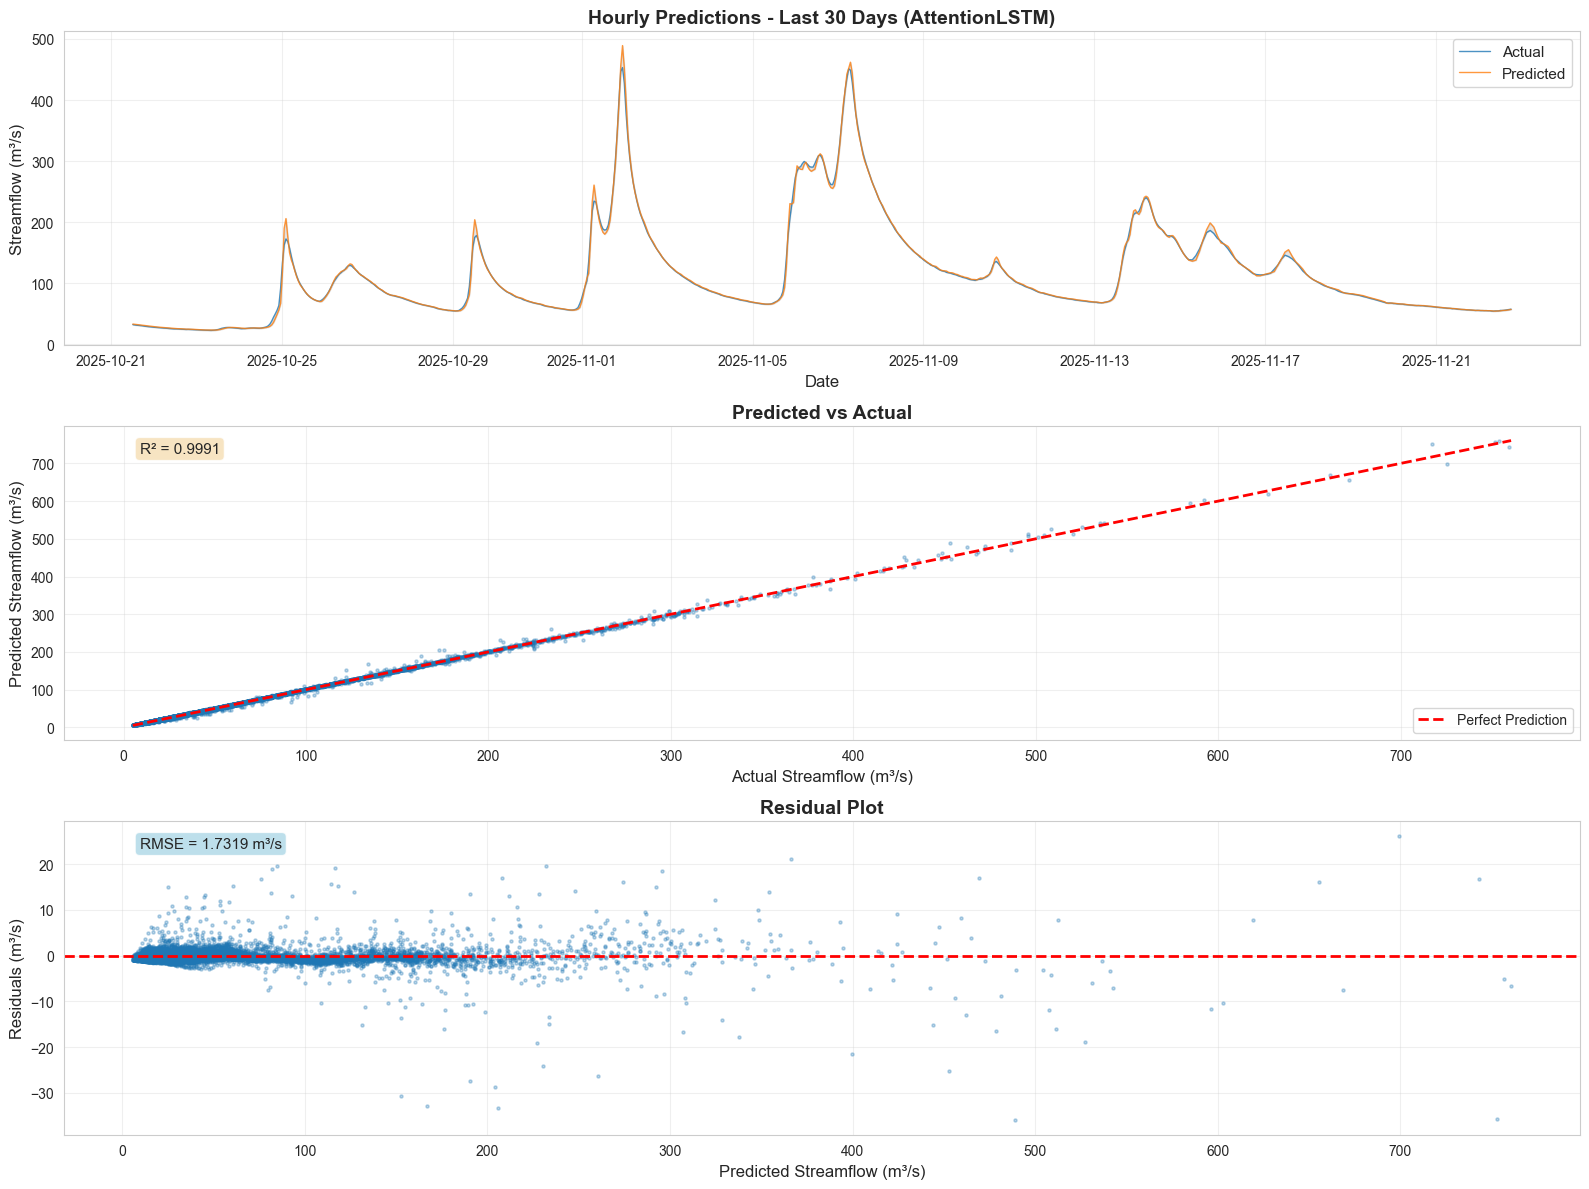

In [17]:
# Extract best model results
best_result = results[best_model_name]
y_true = best_result['test_actuals']
y_pred = best_result['test_preds']

# Get test datetimes for plotting
test_start_idx = train_size + val_size + SEQ_LENGTH
test_dates = df_hourly['datetime'].iloc[test_start_idx:test_start_idx + len(y_true)]

# Plot recent period (last 30 days) to show hourly detail
recent_hours = 30 * 24
recent_dates = test_dates.iloc[-recent_hours:]
recent_true = y_true[-recent_hours:]
recent_pred = y_pred[-recent_hours:]

fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# 1. Last 30 days
axes[0].plot(recent_dates, recent_true, label='Actual', linewidth=1, alpha=0.8)
axes[0].plot(recent_dates, recent_pred, label='Predicted', linewidth=1, alpha=0.8)
axes[0].fill_between(recent_dates, recent_true, recent_pred, alpha=0.2, color='gray')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Streamflow (m³/s)', fontsize=12)
axes[0].set_title(f'Hourly Predictions - Last 30 Days ({best_model_name})', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# 2. Scatter plot
axes[1].scatter(y_true, y_pred, alpha=0.3, s=5)
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Streamflow (m³/s)', fontsize=12)
axes[1].set_ylabel('Predicted Streamflow (m³/s)', fontsize=12)
axes[1].set_title('Predicted vs Actual', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].text(0.05, 0.95, f'R² = {results[best_model_name]["metrics"]["R²"]:.4f}', 
             transform=axes[1].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), fontsize=11)

# 3. Residual plot
residuals = y_true - y_pred
axes[2].scatter(y_pred, residuals, alpha=0.3, s=5)
axes[2].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[2].set_xlabel('Predicted Streamflow (m³/s)', fontsize=12)
axes[2].set_ylabel('Residuals (m³/s)', fontsize=12)
axes[2].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].text(0.05, 0.95, f'RMSE = {results[best_model_name]["metrics"]["RMSE"]:.4f} m³/s', 
             transform=axes[2].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8), fontsize=11)

plt.tight_layout()
plt.show()

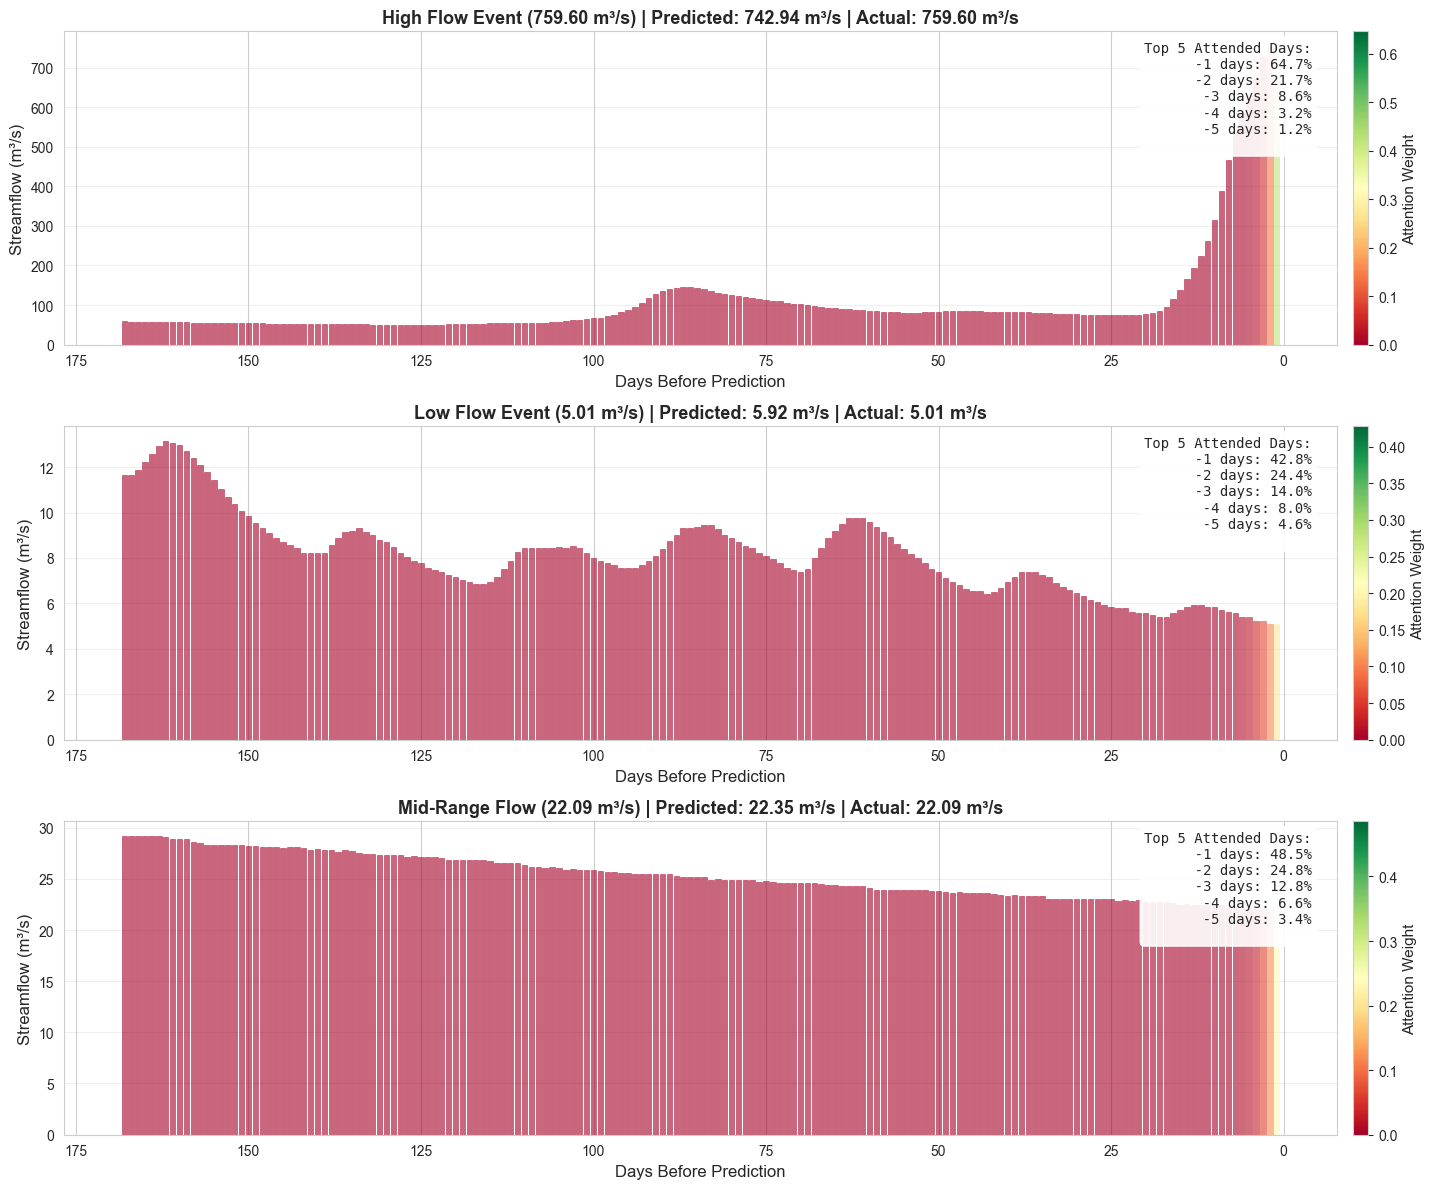


ATTENTION MECHANISM INSIGHTS

The color coding shows which historical days the model focuses on:
  🟢 Green = High attention (important for prediction)
  🟡 Yellow = Medium attention
  🔴 Red = Low attention (less important)

Typically, the model pays most attention to:
  • Recent days (yesterday and past week)
  • Days with similar flow patterns to the target day
  • Critical events (peaks, drops) that indicate trend changes


In [18]:
attention_model = results['AttentionLSTM']['model']

# Attention weight visualization
def get_attention_weights(model, input_seq):
    """Extract attention weights from the AttentionLSTM model."""
    model.eval()
    with torch.no_grad():
        # Get LSTM outputs
        lstm_out, _ = model.lstm(input_seq)
        
        # Calculate attention weights
        attention_weights = model.attention(lstm_out)
        attention_weights = torch.softmax(attention_weights, dim=1)
        
    return attention_weights.squeeze().cpu().numpy()


# Analyze attention for different types of events
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Find interesting events in test set
high_flow_idx = np.argmax(y_true)  # Peak flow event
low_flow_idx = np.argmin(y_true)   # Low flow event
mid_idx = len(y_true) // 2         # Random mid-period

events = [
    (high_flow_idx, f'High Flow Event ({y_true[high_flow_idx]:.2f} m³/s)', 0),
    (low_flow_idx, f'Low Flow Event ({y_true[low_flow_idx]:.2f} m³/s)', 1),
    (mid_idx, f'Mid-Range Flow ({y_true[mid_idx]:.2f} m³/s)', 2)
]

for idx, title, ax_idx in events:
    # Get the input sequence for this prediction
    sample_X = X_test_tensor[idx:idx+1]
    
    # Get attention weights
    attention = get_attention_weights(attention_model, sample_X)
    
    # Inverse transform the input sequence
    input_seq = scaler.inverse_transform(
        sample_X.squeeze().cpu().numpy().reshape(-1, 1)
    ).flatten()
    
    # Days in the past (0 = yesterday, 59 = 60 days ago)
    days_back = np.arange(SEQ_LENGTH, 0, -1)
    
    # Create bar plot with attention weights
    bars = axes[ax_idx].bar(days_back, input_seq, alpha=0.6, edgecolor='black', linewidth=0.5)
    
    # Color bars by attention weight
    colors = plt.cm.RdYlGn(attention)
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    axes[ax_idx].set_xlabel('Days Before Prediction', fontsize=12)
    axes[ax_idx].set_ylabel('Streamflow (m³/s)', fontsize=12)
    axes[ax_idx].set_title(f'{title} | Predicted: {y_pred[idx]:.2f} m³/s | Actual: {y_true[idx]:.2f} m³/s', 
                           fontsize=13, fontweight='bold')
    axes[ax_idx].grid(True, alpha=0.3, axis='y')
    axes[ax_idx].invert_xaxis()
    
    # Add colorbar for attention weights
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, norm=plt.Normalize(vmin=0, vmax=attention.max()))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes[ax_idx], pad=0.01)
    cbar.set_label('Attention Weight', fontsize=11)
    
    # Show top 5 most attended days
    top_5_indices = np.argsort(attention)[-5:][::-1]
    top_5_days = SEQ_LENGTH - top_5_indices
    top_5_weights = attention[top_5_indices] * 100
    
    info_text = "Top 5 Attended Days:\n"
    for day, weight in zip(top_5_days, top_5_weights):
        info_text += f"  -{day} days: {weight:.1f}%\n"
    
    axes[ax_idx].text(0.98, 0.97, info_text, transform=axes[ax_idx].transAxes,
                     verticalalignment='top', horizontalalignment='right',
                     bbox=dict(boxstyle='round', facecolor='white', alpha=0.9), 
                     fontsize=10, family='monospace')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("ATTENTION MECHANISM INSIGHTS")
print("="*80)
print("\nThe color coding shows which historical days the model focuses on:")
print("  🟢 Green = High attention (important for prediction)")
print("  🟡 Yellow = Medium attention")
print("  🔴 Red = Low attention (less important)")
print("\nTypically, the model pays most attention to:")
print("  • Recent days (yesterday and past week)")
print("  • Days with similar flow patterns to the target day")
print("  • Critical events (peaks, drops) that indicate trend changes")

## Summary

### Key Findings:
- **Dataset**: Last 10 years (2015-2025) at 15-minute intervals, aggregated to hourly
- **Training Data**: ~60,000 hourly records (vs 207,000 for full 36-year dataset)
- **Lookback**: 7 days (168 hours) vs daily model's 60 days
- **Models**: Same 4 architectures as daily model

### Research Question:
**Does sub-daily resolution improve predictions for rain-dominated systems?**

Compare results above to daily model (R² ≈ 0.66-0.67). If hourly R² is higher, it suggests:
- Storm hydrograph shape contains predictive information
- Noah Effect (sudden events) can be partially captured at finer resolution
- Models benefit from seeing intra-day variability

If similar/worse performance:
- Daily aggregation already captures the important dynamics
- Hourly noise may obscure signal
- 7-day lookback may be too short (could try longer sequences)

### Performance Notes:
- 10-year window provides recent climate patterns
- Faster training than full 36-year dataset
- Still sufficient data for deep learning (tens of thousands of sequences)

### Next Steps:
- If results are promising, try full 36-year dataset
- Try different sequence lengths (14 days = 336 hours)
- Experiment with multi-horizon forecasting (predict next 6-24 hours)
- Add precipitation data (critical for rain-dominated systems)
- Compare attention patterns: What hours does the model focus on?